In [119]:
from torch.utils.data import Dataset
from torchvision import transforms
from datasets import load_dataset
import random

class Flickr30kDataset(Dataset):
    def __init__(self, split="train", transform=None):
        self.dataset = self._prepare_data(split)
        self.transform = transform

    @staticmethod
    def _prepare_data(split):
        if split not in ("train", "val", "test"):
            raise ValueError(f"split must be either 'train', 'va' or 'test'. Given {split}")

        dataset = load_dataset("nlphuji/flickr30k")["test"]
        dataset = dataset.remove_columns(["sentids", "img_id", "filename"])
        return dataset.filter(lambda example: example["split"] == split)


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        captions = item['caption']
        caption = random.choice(captions)

        if self.transform:
            image = self.transform(image)

        return image, caption

# Image transformations for MobileNetV2 trained on imagenet-1k
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = Flickr30kDataset(split='train', transform=transform)
val_dataset = Flickr30kDataset(split='val', transform=transform)
test_dataset = Flickr30kDataset(split='test', transform=transform)


In [115]:
from pathlib import Path
import fiftyone as fo

def create_filckr32k_dashboard(split, max_samples=25, with_predictions=False, top_k=5, top_k_indices=None):
    fo_dataset = fo.Dataset(f"flickr30k-{split}", overwrite=True)
    samples = []
    raw_dataset = Flickr30kDataset(split=split, transform=None)
    save_path = f"./{split}_images"
    save_path = Path(save_path)
    save_path.mkdir(exist_ok=True)
    for i, (image, caption) in enumerate(raw_dataset):
        image = image.convert("RGB")
        filepath = str(save_path / f"{i}.png")
        image.save(filepath)
        sample = fo.Sample(filepath=filepath)
        sample["ground_truth"] = fo.Classification(label=caption)
        if with_predictions:
            assert top_k_indices is not None
            for idx in range(top_k):
                matching_caption_idx = top_k_indices[i][idx].item()
                _, matching_caption = raw_dataset[matching_caption_idx]
                sample[f"predictions_{idx}"] = fo.Classification(label=matching_caption)

        samples.append(sample)

        if i > max_samples: break

    fo_dataset.add_samples(samples)
    return fo_dataset

fo_train_dataset = create_filckr32k_dashboard(split="train")

 100% |███████████████████| 27/27 [27.6ms elapsed, 0s remaining, 976.8 samples/s]     


In [116]:
fosess = fo.launch_app(fo_train_dataset)

In [117]:
fosess.close()

In [2]:
import torch
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F

tokenizer = AutoTokenizer.from_pretrained('Snowflake/snowflake-arctic-embed-m')
text_model = AutoModel.from_pretrained('Snowflake/snowflake-arctic-embed-m', add_pooling_layer=False)
text_model.eval()

def text_embeddings(texts):
    tokens = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt", max_length=512)
    with torch.no_grad():
        query_embeddings = text_model(**tokens)[0][:, 0]

    normalized = F.normalize(query_embeddings, p=2, dim=1)
    return normalized

In [3]:
import torch
import torch.nn.functional as F
from transformers import MobileNetV2ForImageClassification

image_model = MobileNetV2ForImageClassification.from_pretrained(
    "google/mobilenet_v2_1.0_224"
)
image_model.eval()
def image_embeddings(images):
    with torch.no_grad():
        image_logits = image_model(images).logits

    normalized = F.normalize(image_logits, p=2, dim=1)
    return normalized


In [82]:
import torch
import torch.nn as nn

class CustomMultiModalModel(nn.Module):
    def __init__(self, text_embedding_dim=768, image_embedding_dim=1001, common_dim=64):
        super().__init__()
        self.text_transform = nn.Sequential(
            nn.Linear(text_embedding_dim, common_dim),
            nn.ReLU()
        )
        self.image_transform = nn.Sequential(
            nn.Linear(image_embedding_dim, common_dim),
            nn.ReLU()
        )
        self.final = nn.Linear(common_dim, common_dim)

    def forward(self, image_embeddings, text_embeddings):
        transformed_image = self.image_transform(image_embeddings)
        transformed_text = self.text_transform(text_embeddings)
        project_image = self.final(transformed_image)
        project_text = self.final(transformed_text)
        return project_image, project_text

class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=2)

    def forward(self, image_features, text_features):
        logits = self.cosine_similarity(image_features.unsqueeze(0), text_features.unsqueeze(1)) / self.temperature
        batch_size = text_features.shape[0]
        # Labels are the main diagonal, as corresponding text and images are aligned
        labels = torch.arange(batch_size).to(logits.device)
        loss = nn.CrossEntropyLoss()(logits, labels)
        return loss


In [84]:
%%time

import os
from torch.utils.data import DataLoader

os.environ["TOKENIZERS_PARALLELISM"] = "0"

lr = 3e-4
epochs = 5
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = CustomMultiModalModel()
loss_fn = ContrastiveLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_loss_history = []
val_loss_history = []

for epoch in range(1, epochs + 1):
    model.train()
    train_losses = []
    for image_batch, text_batch in train_loader:
        image_features = image_embeddings(image_batch)
        text_features = text_embeddings(text_batch)
        optimizer.zero_grad()
        image_out, text_out = model(image_features, text_features)
        train_loss = loss_fn(image_out, text_out)
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())
        print(f"Epoch {epoch}, Loss: {train_loss.item()}")

    average_train_loss = sum(train_losses) / len(train_losses)
    train_loss_history.append(average_train_loss)
    print(f"Epoch {epoch}, Average train loss: {average_train_loss}")

    torch.save(model.state_dict(), f"custom_multimodal_model_epoch_{epoch}.pt")

    model.eval()
    val_losses = []
    with torch.no_grad():
        for image_batch, text_batch in val_loader:
            image_features = image_embeddings(image_batch)
            text_features = text_embeddings(text_batch)
            image_out, text_out = model(image_features, text_features)
            val_loss = loss_fn(image_out, text_out)
            val_losses.append(val_loss.item())

    average_val_loss = sum(val_losses) / len(val_losses)
    val_loss_history.append(average_val_loss)
    print(f"Epoch {epoch}, Average validation loss: {average_val_loss}")
    print("=" * 80)


Epoch 1, Loss: 4.159326553344727
Epoch 1, Loss: 4.158186912536621
Epoch 1, Loss: 4.155946254730225
Epoch 1, Loss: 4.1591973304748535
Epoch 1, Loss: 4.1529645919799805
Epoch 1, Loss: 4.152851104736328
Epoch 1, Loss: 4.153634548187256
Epoch 1, Loss: 4.1537322998046875
Epoch 1, Loss: 4.153207302093506
Epoch 1, Loss: 4.148106575012207
Epoch 1, Loss: 4.145979404449463
Epoch 1, Loss: 4.147611618041992
Epoch 1, Loss: 4.144014835357666
Epoch 1, Loss: 4.137998580932617
Epoch 1, Loss: 4.141138553619385
Epoch 1, Loss: 4.131735801696777
Epoch 1, Loss: 4.132875919342041
Epoch 1, Loss: 4.130141258239746
Epoch 1, Loss: 4.1253790855407715
Epoch 1, Loss: 4.110469818115234
Epoch 1, Loss: 4.1133713722229
Epoch 1, Loss: 4.096147060394287
Epoch 1, Loss: 4.104233264923096
Epoch 1, Loss: 4.096949100494385
Epoch 1, Loss: 4.087977409362793
Epoch 1, Loss: 4.07309627532959
Epoch 1, Loss: 4.083780288696289
Epoch 1, Loss: 4.079373836517334
Epoch 1, Loss: 4.095587253570557
Epoch 1, Loss: 4.024467468261719
Epoch 1, 

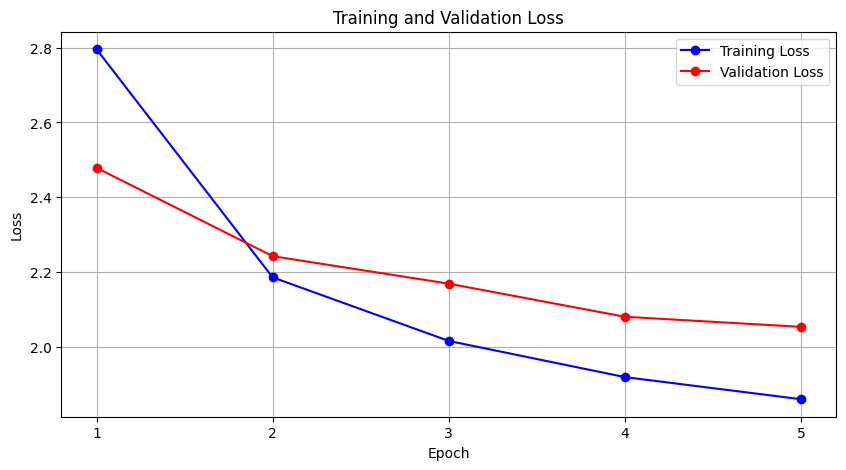

In [86]:
import matplotlib.pyplot as plt

plot_epochs = range(1, len(train_loss_history) + 1)
plt.figure(figsize=(10, 5))
plt.plot(plot_epochs, train_loss_history, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(plot_epochs, val_loss_history, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(plot_epochs)
plt.grid(True)
plt.legend()
plt.show()


In [121]:
import torch

example_image_inputs = torch.zeros((1, 3, 224, 224))
with torch.no_grad():
    traced_image_model = torch.jit.trace(image_model, example_image_inputs, strict=False)

traced_image_model.save("image_embedding.torchscript")

/home/ubuntu/workspace/stable-venv/lib/python3.10/site-packages/transformers/modeling_utils.py:4225: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
/home/ubuntu/workspace/stable-venv/lib/python3.10/site-packages/transformers/models/mobilenet_v2/modeling_mobilenet_v2.py:258: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  in_height = int(features.shape[-2])
/home/ubuntu/workspace/stable-venv/lib/python3.10/site-packages/transformers/models/mobilenet_v2/modeling_mobilenet_v2.py:259: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as

In [122]:
example_text_inputs = {
    "input_ids": torch.zeros((1, 512), dtype=torch.long),
    "token_type_ids": torch.zeros((1, 512), dtype=torch.long),
    "attention_mask": torch.zeros((1, 512), dtype=torch.long),
}
with torch.no_grad():
    traced_text_model = torch.jit.trace(text_model, example_kwarg_inputs=dict(example_text_inputs), strict=False)

traced_text_model.save("text_embedding.torchscript")

In [123]:
model = CustomMultiModalModel()
model.load_state_dict(torch.load("custom_multimodal_model_epoch_2.pt"))
model.eval()
example_image_embeddings = torch.rand(1, 1001)
example_text_embeddings = torch.rand(1, 768)

with torch.no_grad():
    traced_script_module = torch.jit.trace(model, (example_image_embeddings, example_text_embeddings))

traced_script_module.save("custom_multimodal_model.torchscript")

In [90]:
%%time

from max import engine

session = engine.InferenceSession()

max_image_embedding = session.load("image_embedding.torchscript", engine.TorchLoadOptions([
    engine.TorchInputSpec(shape=[1, 3, 224, 224], dtype=engine.DType.float32)
]))
max_text_embedding = session.load("text_embedding.torchscript", engine.TorchLoadOptions([
    engine.TorchInputSpec(shape=[1, None], dtype=engine.DType.int64),
    engine.TorchInputSpec(shape=[1, None], dtype=engine.DType.int64),
    engine.TorchInputSpec(shape=[1, None], dtype=engine.DType.int64),
]))

max_custom_multimodal = session.load("custom_multimodal_model.torchscript", engine.TorchLoadOptions([
    engine.TorchInputSpec(shape=[1, 1001], dtype=engine.DType.float32),
    engine.TorchInputSpec(shape=[1, 768], dtype=engine.DType.float32),
]))

CPU times: user 6min 39s, sys: 1min 5s, total: 7min 45s
Wall time: 2min 30s


Compiling model     
Done!
Compiling model.    
Done!
Compiling model     
Done!


In [126]:
print(max_image_embedding.input_metadata)
print(max_image_embedding.output_metadata)
print("="*80)
print(max_text_embedding.input_metadata)
print(max_text_embedding.output_metadata)
print("="*80)
print(max_custom_multimodal.input_metadata)
print(max_custom_multimodal.output_metadata)

[TensorSpec(shape=[1, 3, 224, 224], dtype=DType.float32, name=pixel_values)]
[TensorSpec(shape=[], dtype=DType.unknown, name=result0)]
[TensorSpec(shape=[1, None], dtype=DType.int64, name=input_ids), TensorSpec(shape=[1, None], dtype=DType.int64, name=attention_mask), TensorSpec(shape=[1, None], dtype=DType.int64, name=token_type_ids)]
[TensorSpec(shape=[], dtype=DType.unknown, name=result0)]
[TensorSpec(shape=[1, 1001], dtype=DType.float32, name=image_embeddings), TensorSpec(shape=[1, 768], dtype=DType.float32, name=text_embeddings)]
[TensorSpec(shape=[1, 64], dtype=DType.float32, name=result0), TensorSpec(shape=[1, 64], dtype=DType.float32, name=result1)]


In [93]:
%%time

import torch

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

all_image_embeddings = []
all_text_embeddings = []
for image, caption in test_loader:
    img_emb = max_image_embedding.execute(pixel_values=image)["result0"]["logits"]
    tokenized_caption = tokenizer(caption, padding=True, truncation=True, return_tensors="pt", max_length=512)
    txt_emb = max_text_embedding.execute(**tokenized_caption)["result0"]["last_hidden_state"][:, 0, :]

    ret = max_custom_multimodal.execute(image_embeddings=img_emb, text_embeddings=txt_emb)
    projected_image_emb, projected_text_emb = ret["result0"], ret["result1"]

    all_image_embeddings.append(torch.from_numpy(projected_image_emb))
    all_text_embeddings.append(torch.from_numpy(projected_text_emb))

assert len(all_image_embeddings) == len(all_text_embeddings) == len(test_dataset)

all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
all_text_embeddings = torch.cat(all_text_embeddings, dim=0)

CPU times: user 8min 39s, sys: 23.3 s, total: 9min 2s
Wall time: 1min 4s


In [94]:
%%time

import torch.nn.functional as F
cosine_similarities = F.cosine_similarity(all_image_embeddings.unsqueeze(1), all_text_embeddings.unsqueeze(0), dim=2)

k = 5
top_k_values, top_k_indices = torch.topk(cosine_similarities, k=k, dim=1)

CPU times: user 496 ms, sys: 0 ns, total: 496 ms
Wall time: 24.3 ms


In [133]:
cosine_similarities.shape

torch.Size([1000, 1000])

In [127]:
%%time

fo_test_dataset = create_filckr32k_dashboard(split="test", with_predictions=True, top_k=k, top_k_indices=top_k_indices)

 100% |███████████████████| 27/27 [81.0ms elapsed, 0s remaining, 333.2 samples/s]  
CPU times: user 2.3 s, sys: 29.3 ms, total: 2.33 s
Wall time: 2.97 s


In [132]:
fosess = fo.launch_app(fo_test_dataset)

In [131]:
fosess.close()